## Connexion au drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

DATA_DIR =  '/content/gdrive/MyDrive/teaching/pizza'

Mounted at /content/gdrive/


## Bibliothèques nécessaires et connexion au GPU

In [2]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')


import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

# Métrique
from sklearn.metrics import roc_curve, auc
!pip install torchmetrics
from torchmetrics.classification import MultilabelAccuracy
!pip install torcheval
from torcheval.metrics import MultilabelAccuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
  !nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.7 MB/s eta 0:00:00
Tue Jan 30 08:17:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Defa

## Données

### Téléchargement et décompression

In [ ]:
!wget -P /content/gdrive/MyDrive/teaching/pizza/ http://pizzagan.csail.mit.edu/pizzaGANsyntheticdata.zip
!unzip '/content/gdrive/MyDrive/teaching/pizza/pizzaGANsyntheticdata.zip' -d '/content/gdrive/MyDrive/teaching/pizza/

In [3]:
y_all = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/train/trainLabels.txt'))
x_all = np.arange(y_all.shape[0])

# Create train, val and test splits
# x_train and x_val only contain image number (not the raw data)

x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

print(y_train.shape)

y_test = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/test/testLabels.txt'))
x_test = np.arange(y_test.shape[0])

print(y_test.shape)

(3976, 10)
(497, 10)


### Affichage d'un exemple et de ses classes

In [4]:
classes=['pepporoni','champignon','poivron','olives','basilic','viande','brocoli','ananas','tomate','oignon']

In [5]:
def decode_label(target,classes=classes):
  result=[]
  for x,i in enumerate(target) :
    if i :
      result.append(classes[x])
  return '/'.join(result)


La fonction decode_label est  conçue pour décoder les prédictions du modèle à partir d'un vecteur binaire en utilisant la liste des classes.

0046.png


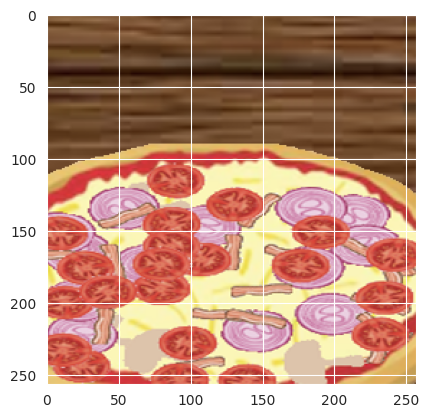

champignon/viande/tomate/oignon


In [6]:
idx = 45

img_name = "{:04d}.png".format(idx+1)
print(img_name)

img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img = Image.open(os.path.join(img_path, img_name))

plt.imshow(img)
plt.show()
print(decode_label(y_all[idx]))

### Sauvegarde et compression des images

In [7]:
train_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train')

# Test if the numpy file exists
if (os.path.exists(os.path.join(train_data_path, 'img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(train_data_path, 'img_data_224.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []

  for idx in tqdm(x_all):
      img_name = "{:04d}.png".format(idx+1)
      x = Image.open(os.path.join(train_data_path, 'images', img_name))
      img_all.append(np.array(x.resize((224,224))))

  np.savez_compressed(os.path.join(train_data_path,'img_data_224.npz'), img_data=np.array(img_all))

Ce bloc de code optimise le temps de chargement des données d'entraînement en prétraitant les images et en les sauvegardant dans un format compressé pour éviter de recalculer ces transformations à chaque exécution.

### Classe du Dataset

In [8]:
class myDataset(Dataset):
    """Pizza dataset"""

    def __init__(self, x_idx, y, img_path='/content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images', img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data

    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y

    def __len__(self):
        return int(len(self.x_idx))


### Dataloader

In [9]:
img_all=np.array(img_all)

batch_size = 25

input_size = 128

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])

kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img_data_train = img_all[x_train,:,:,:]
train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

img_data_val = img_all[x_val,:,:,:]
val_set_raw = myDataset(x_val, y_val, img_path=train_data_path, img_data=img_data_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')

test_set_raw = myDataset(x_test, y_test, img_path=test_data_path, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, **kwargs)


* Ce bloc de code implémente des transformations d'images essentielles telles que le retournement horizontal, vertical, l'ajustement des couleurs, le redimensionnement pour l'augmentation des images pour l'entrainement et une normalisation pour la mise en échelle des valeurs des pixels des images de tous les images.
* Les DataLoader de PyTorch facilitent l'itération sur les ensembles de données, divisant les données en lots(batch), les chargeant en parallèle, et fournissant ces lots au modèle pendant l'entraînement. Ils améliorent l'efficacité du traitement des données, en particulier lorsque le jeu de données est volumineux.
* On vérifie si un GPU est disponible et définit le nombre de travailleurs et la mémoire épinglée en conséquence.
* La conversion des étiquettes en tensors assure la compatibilité avec les opérations PyTorch et la possibilité de calculer le gradient lors de la rétropropagation.

###Visualisation du Dataloader

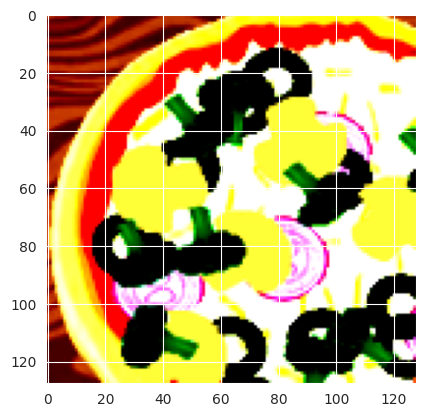

torch.Size([25, 3, 128, 128])


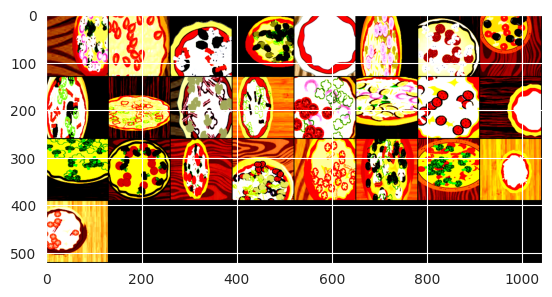

In [10]:
# Show dataset sample
x,y = test_set_raw[45]
#print(x,y)

plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

# Show batch of images
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))

### Distribution des classes

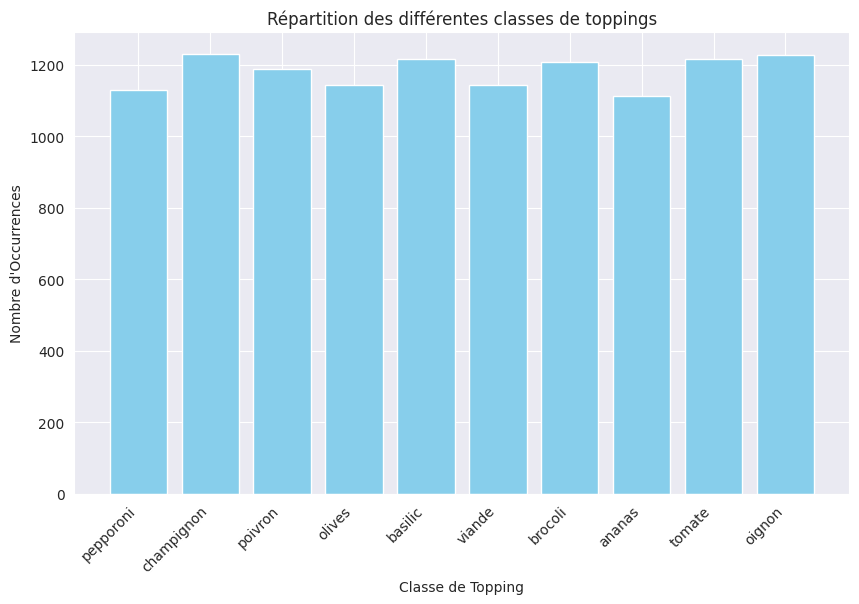

In [11]:
# Compter le nombre d'occurrences de chaque classe
class_counts = np.sum(np.array(y_train), axis=0)

# Positions sur l'axe x pour chaque classe
class_positions = np.arange(len(class_counts))

plt.figure(figsize=(10, 6))
plt.bar(class_positions, class_counts, color='skyblue')
plt.title('Répartition des différentes classes de toppings')
plt.xlabel('Classe de Topping')
plt.ylabel("Nombre d'Occurrences")

plt.xticks(class_positions, classes, rotation=45, ha='right')

plt.show()

**Interprétation**
* L'uniformité des hauteurs des histogrammes suggère que chaque classe de topping est représentée de manière similaire dans nos données synthétiques. Les fréquences d'apparition des classes sont très proches.
* Une distribution équilibrée peut simplifier le processus d'apprentissage du modèle, éliminant les défis potentiels liés à des classes sous-représentées. Cela favorise une convergence plus rapide du modèle.

## Réseau de neurones convolutif ResNet

Notre idée repose sur un réseau de neurones inspirés par ResNet-50, une architecture de pointe développée par Microsoft en 2015 pour la classification des images.  
Nous avons choisi cette architecture en raison de l'introduction de connexions résiduelles.
Les connexions résiduelles, mathématiquement formulées comme : Output=F(x)+x.

Cette formulation signifie que la sortie de chaque bloc de convolution est
combinée à l'entrée de ce même bloc.
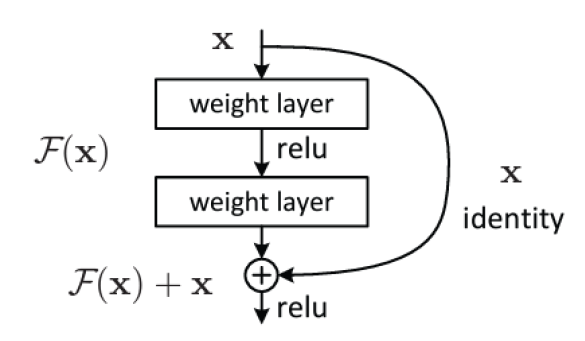

**Formulation mathématique :**

H(x) = F(x) + x

Où

X est l'entrée de l'ensemble des couches

F(X) est la fonction Résiduelle

H(X) est la fonction de mappage de l'entrée à la sortie

**Références :**

https://www.analyticsvidhya.com/blog/2023/02/deep-residual-learning-for-image-recognition-resnet-explained/

https://www.analyticsvidhya.com/blog/2023/02/deep-residual-learning-for-image-recognition-resnet-explained/




Dans notre architecture de réseau, nous avons mis en œuvre les principes de fonctionnement d'un ResNet en définissant un bloc résiduel selon les étapes suivantes :

1-À l'entrée du bloc résiduel, nous effectuons une convolution, une normalisation avec nn.BatchNorm2d, et une activation avec une fonction ReLU, ce qui nous donne notre entrée x.

2-La fonction résiduelle f est calculée en appliquant la même séquence de convolution, normalisation et activation deux fois.

3-À la sortie du bloc résiduel, nous additionnons l'entrée x et
f(x). Ainsi, nous implémentons le principe d'un réseau résiduel.

Par ailleurs, dans certains blocs de notre architecture, nous avons ajouté des opérations de MaxPooling afin de réduire la taille de l'image.

Nous avons remarqué une redondance dans les étapes de notre implémentation. Pour remédier à cela, nous avons choisi de factoriser ces étapes en utilisant la fonction **conv_block**.



In [12]:
def conv_block(inchannels,out_channels, pool=False):
    layers = [nn.Conv2d(inchannels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

Nous avons inclus la fonction **nn.Dropout** dans la dernière couche de notre architecture afin de prévenir le surapprentissage. Cette fonction agit en ignorant aléatoirement certaines valeurs de l'entrée, avec une probabilité définie que nous avons fixée à p=0.2. Cette approche permet de réguler la complexité du modèle et d'améliorer sa capacité à généraliser sur de nouvelles données en réduisant la dépendance excessive aux caractéristiques spécifiques de l'ensemble d'entraînement.

Ensuite, nous effectuons une classification linéaire des composants obtenus. Nous activons ces composants avec la fonction F.sigmoid.

La définition mathématique de la fonction sigmoid est la suivante :

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

Un composant est prédit comme classe 0 (absent) s'il est négatif, et comme classe 1 (présent) dans le cas contraire.

In [13]:
# network class
class SimpleCNN(nn.Module):
# Network requires 128x128 input images
  def __init__(self,inchanels=3,nlabel = 10):
      super().__init__()

    # define here the convolutions and linear layers
      self.conv1 = conv_block(inchanels,64)
      self.res= nn.Sequential(conv_block(64, 64), conv_block(64, 64)) # 64 x 128 x 128

      self.conv2 = conv_block(64, 128, pool=True) #128 x 32 x 32
      self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

      self.conv3 = conv_block(128, 256, pool=True) #256 x 8 x 8
      self.res3 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

      self.conv4 = conv_block(256, 512, pool=True) #512 x 2 x 2
      self.res4 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

      self.classifier = nn.Sequential(nn.MaxPool2d(2), #512 x 1 x 1
                                        nn.Flatten(),# 512 * 512 x 1
                                        nn.Dropout(0.2),
                                        nn.Linear(512, nlabel))
  def forward(self, xb):
        out = self.conv1(xb)
        out = self.res(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = F.sigmoid(out)
        return out


#network=SimpleCNN()
#print(network)
#network=network.cuda()


## Fonction d'apprentissage

* **Boucle d'Époques** :
La fonction itère sur le nombre d'époques spécifié .
Pour chaque époque, elle effectue une phase d'entraînement et une phase de validation.
* **Phase d'Entraînement**:
La fonction met le modèle en mode d'entraînement.
Elle itère sur les lots du chargeur d'entraînement.
Pour chaque lot, elle effectue une propagation avant, un calcul de perte, une rétropropagation des gradients, et une mise à jour des poids du modèle avec l'optimiseur.
Elle enregistre la perte moyenne et la précision moyenne d'entraînement pour l'époque.


* **Phase de Validation**:
La fonction met le modèle en mode d'évaluation .
Elle itère sur les lots du chargeur de validation .
Pour chaque lot, elle effectue une propagation avant, compare les prédictions seuillées avec les vraies étiquettes, et calcule l'exactitude.
Elle enregistre l'exactitude moyenne de validation pour l'époque
* **Sauvegarde du Meilleur Modèle**  :
La fonction sauvegarde les poids du modèle s'il obtient une meilleure exactitude sur l'ensemble de validation.


* **Ajustement du Taux d'Apprentissage** :
Si un ordonnanceur (scheduler) est fourni, la fonction utilise l'ordonnanceur pour ajuster le taux d'apprentissage.

* **Résultats Finaux** :
Une fois toutes les époques complétées, la fonction charge les meilleurs poids du modèle. Elle renvoie le modèle final, les performances d'entraînement , les performances de validation , et les pertes d'entraînement.




In [14]:
from IPython.display import clear_output
import copy
network=SimpleCNN()
network=network.cuda()

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler=False, num_epochs=5):
    # list for saving accuracies
    train_perf = []
    test_perf = []
    train_losses= []

    accuracy_metric = MultilabelAccuracy()
    # best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        scores=[]
        for inputs, labels in trainloader:
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.float()
            labels = labels.float()
            accuracy_metric.update(outputs,labels)
            scores.append(accuracy_metric.compute())
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        train_losses.append(epoch_loss)
        train_perf.append(sum(scores)/len(scores))
        # Validation phase
        model.eval()  # Set model to evaluation mode
        all_preds = []
        all_labels = []
        scores=[]
        with torch.no_grad():
              for inputs, labels in valloader:
                   inputs = inputs.cuda()
                   labels = labels.cuda()

        # Forward pass
                   outputs = model(inputs)

        # Threshold outputs for multilabel classification
                   threshold = 0.5

                   preds = (outputs > threshold).float()
                   scores.append(accuracy_score(labels.cpu(),preds.cpu()))
                   all_preds.append(preds.cpu().numpy())
                   all_labels.append(labels.cpu().numpy())


        epoch_acc=sum(scores)/len(scores)
        print("Training Loss: {:.4f} | Epoch Accuracy: {:.4f}".format(epoch_loss, epoch_acc))


        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        test_perf.append(epoch_acc)

        # Adjust learning rate if scheduler is provided

        if scheduler:
            scheduler.step()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_perf, test_perf, train_losses


# Etude sur le scheduler variation de gamma en nombre d'époch constant
Dans le cadre de notre étude, nous avons opté pour l'utilisation du scheduler de type ["step_scheduler"](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) pour l'apprentissage (un outil utilisé pour ajuster dynamiquement le taux d'apprentissage au fil du temps, généralement basé sur le nombre d'époques ou le nombre de pas). \
Un des paramétres de ce scheduler est le paramètre Gamma un facteur multiplicatif par lequel le taux d'apprentissage diminue.\
Un taux d'apprentissage élevé peut provoquer des oscillations ou une divergence.En diminuant progressivement le taux d'apprentissage, on favorise une convergence plus stable, évitant les minima locaux sous-optimaux et permettant des ajustements plus fins vers la fin de l'entraînement. \
Cette section vise à examiner l'influence de ce paramètre sur la précision  de notre modèle . Nous allons tester les différentes valeurs suivantes de Gamma {0.05,0.1,0.3,0.7}. Notre objectif est de déterminer la meilleure valeur à sélectionner.\
L'évaluation de notre modèle doit prendre en considération à la fois la valeur de gamma et le nombre d'époques, bien que ces deux paramètres soient interdépendants. Pour les besoins de cette section, nous supposons qu'ils sont indépendants et évaluons l'apprentissage de notre modèle en utilisant un nombre constant de 10 époques.










































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































**Pour gamma=0.05**

In [15]:
import torch.optim as optim
from torch.optim import lr_scheduler
gamma=0.05
nlabel=10
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader
tag="my_model"



# Transfer network to GPU
network=SimpleCNN()
network=network.cuda()

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_dataloader),gamma=gamma)
# Learning
learned_model, train_acc, test_accuracy, train_loss = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer,scheduler, num_epochs=10)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
test_accuracy=(np.array(test_accuracy).mean())


Epoch 0/9
----------
Training Loss: 0.5373 | Epoch Accuracy: 0.0988
Epoch 1/9
----------
Training Loss: 0.4059 | Epoch Accuracy: 0.1940
Epoch 2/9
----------
Training Loss: 0.2872 | Epoch Accuracy: 0.3485
Epoch 3/9
----------
Training Loss: 0.2135 | Epoch Accuracy: 0.5035
Epoch 4/9
----------
Training Loss: 0.1663 | Epoch Accuracy: 0.5835
Epoch 5/9
----------
Training Loss: 0.1297 | Epoch Accuracy: 0.6900
Epoch 6/9
----------
Training Loss: 0.0940 | Epoch Accuracy: 0.7363
Epoch 7/9
----------
Training Loss: 0.1046 | Epoch Accuracy: 0.8090
Epoch 8/9
----------
Training Loss: 0.0947 | Epoch Accuracy: 0.8605
Epoch 9/9
----------
Training Loss: 0.0834 | Epoch Accuracy: 0.8398


In [16]:
testloader = test_dataloader
network=torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
# set the model to evaluation mode
network.eval()
scores=[]
# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(testloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)
        threshold = 0.5
        preds = (outputs > threshold).float()
        scores.append(accuracy_score(targets.cpu(),preds.cpu()))

test_val=np.array(scores).mean()
scores_train=[]
# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(trainloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)
        threshold = 0.5
        preds = (outputs > threshold).float()
        scores_train.append(accuracy_score(targets.cpu(),preds.cpu()))

train_val=np.array(scores_train).mean()
dict={'0.05':[test_accuracy,test_val,train_val]}




100%|█████████████████████████████████████████| 160/160 [00:12<00:00, 13.15it/s]


**Pour gamma=0.1**

In [17]:
import torch.optim as optim
from torch.optim import lr_scheduler
gamma=0.1
nlabel=10
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader
tag="my_model"



# Transfer network to GPU
network=SimpleCNN()
network=network.cuda()

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_dataloader),gamma=gamma)
# Learning
learned_model, train_acc, test_accuracy, train_loss = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer,scheduler, num_epochs=10)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
test_accuracy=(np.array(test_accuracy).mean())



Epoch 0/9
----------
Training Loss: 0.5151 | Epoch Accuracy: 0.0798
Epoch 1/9
----------
Training Loss: 0.3757 | Epoch Accuracy: 0.0925
Epoch 2/9
----------
Training Loss: 0.2795 | Epoch Accuracy: 0.3373
Epoch 3/9
----------
Training Loss: 0.2093 | Epoch Accuracy: 0.4470
Epoch 4/9
----------
Training Loss: 0.1615 | Epoch Accuracy: 0.6113
Epoch 5/9
----------
Training Loss: 0.1230 | Epoch Accuracy: 0.6225
Epoch 6/9
----------
Training Loss: 0.1033 | Epoch Accuracy: 0.7258
Epoch 7/9
----------
Training Loss: 0.0995 | Epoch Accuracy: 0.8340
Epoch 8/9
----------
Training Loss: 0.0730 | Epoch Accuracy: 0.6980
Epoch 9/9
----------
Training Loss: 0.0837 | Epoch Accuracy: 0.8523


In [18]:
testloader = test_dataloader

network=torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
# set the model to evaluation mode
network.eval()
# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(testloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)
        threshold = 0.5
        preds = (outputs > threshold).float()

test_val=np.array(scores).mean()



testloader = test_dataloader

network=torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
# set the model to evaluation mode
network.eval()
scores_train=[]
# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(trainloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)
        threshold = 0.5
        preds = (outputs > threshold).float()
        scores_train.append(accuracy_score(targets.cpu(),preds.cpu()))

train_val=np.array(scores_train).mean()



dict['0.1']=[test_accuracy,test_val,train_val]



100%|█████████████████████████████████████████| 160/160 [00:14<00:00, 11.39it/s]


**Pour gamma=0.3**

In [19]:
import torch.optim as optim
from torch.optim import lr_scheduler
gamma=0.3
nlabel=10
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader
tag="my_model"



# Transfer network to GPU
network=SimpleCNN()
network=network.cuda()

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_dataloader),gamma=gamma)
# Learning
learned_model, train_acc, test_accuracy, train_loss = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer,scheduler, num_epochs=10)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
test_accuracy=(np.array(test_accuracy).mean())



Epoch 0/9
----------
Training Loss: 0.5191 | Epoch Accuracy: 0.1248
Epoch 1/9
----------
Training Loss: 0.3809 | Epoch Accuracy: 0.2220
Epoch 2/9
----------
Training Loss: 0.2831 | Epoch Accuracy: 0.3830
Epoch 3/9
----------
Training Loss: 0.2091 | Epoch Accuracy: 0.5152
Epoch 4/9
----------
Training Loss: 0.1629 | Epoch Accuracy: 0.6763
Epoch 5/9
----------
Training Loss: 0.1273 | Epoch Accuracy: 0.6980
Epoch 6/9
----------
Training Loss: 0.1082 | Epoch Accuracy: 0.7870
Epoch 7/9
----------
Training Loss: 0.0967 | Epoch Accuracy: 0.7442
Epoch 8/9
----------
Training Loss: 0.1016 | Epoch Accuracy: 0.8625
Epoch 9/9
----------
Training Loss: 0.0620 | Epoch Accuracy: 0.8620


In [20]:
testloader = test_dataloader

network=torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
# set the model to evaluation mode
network.eval()

# create the per
perf_label_test = np.zeros((1,nlabel))
all_labels=[]
all_preds=[]
scores=[]
# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(testloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)
        threshold = 0.5
        preds = (outputs > threshold).float()
        scores.append(accuracy_score(targets.cpu(),preds.cpu()))


test_val=np.array(scores).mean()



scores_train=[]
# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(trainloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)
        threshold = 0.5
        preds = (outputs > threshold).float()
        scores_train.append(accuracy_score(targets.cpu(),preds.cpu()))

train_val=np.array(scores_train).mean()
dict['0.3']=[test_accuracy,test_val,train_val]




100%|█████████████████████████████████████████| 160/160 [00:13<00:00, 11.78it/s]


**Pour gamma =0.7**

In [21]:
import torch.optim as optim
from torch.optim import lr_scheduler
gamma=0.7
nlabel=10
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader
tag="my_model"



# Transfer network to GPU
network=SimpleCNN()
network=network.cuda()

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_dataloader),gamma=gamma)
# Learning
learned_model, train_acc, test_accuracy, train_loss = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer,scheduler, num_epochs=10)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
test_accuracy=(np.array(test_accuracy).mean())



Epoch 0/9
----------
Training Loss: 0.5187 | Epoch Accuracy: 0.1053
Epoch 1/9
----------
Training Loss: 0.3801 | Epoch Accuracy: 0.2448
Epoch 2/9
----------
Training Loss: 0.2824 | Epoch Accuracy: 0.4173
Epoch 3/9
----------
Training Loss: 0.2167 | Epoch Accuracy: 0.5535
Epoch 4/9
----------
Training Loss: 0.1622 | Epoch Accuracy: 0.6102
Epoch 5/9
----------
Training Loss: 0.1382 | Epoch Accuracy: 0.6943
Epoch 6/9
----------
Training Loss: 0.1119 | Epoch Accuracy: 0.7443
Epoch 7/9
----------
Training Loss: 0.0937 | Epoch Accuracy: 0.8593
Epoch 8/9
----------
Training Loss: 0.0852 | Epoch Accuracy: 0.8573
Epoch 9/9
----------
Training Loss: 0.0742 | Epoch Accuracy: 0.7223


In [22]:
testloader = test_dataloader

network=torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
# set the model to evaluation mode
network.eval()
scores=[]
# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(testloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)
        threshold = 0.5
        preds = (outputs > threshold).float()
        scores.append(accuracy_score(targets.cpu(),preds.cpu()))

test_val=np.array(scores).mean()


testloader = test_dataloader

network=torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
# set the model to evaluation mode
network.eval()

scores_train=[]
# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(trainloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)
        threshold = 0.5
        preds = (outputs > threshold).float()
        scores_train.append(accuracy_score(targets.cpu(),preds.cpu()))


train_val=np.array(scores_train).mean()
dict['0.7']=[test_accuracy,test_val,train_val]


100%|█████████████████████████████████████████| 160/160 [00:12<00:00, 12.45it/s]


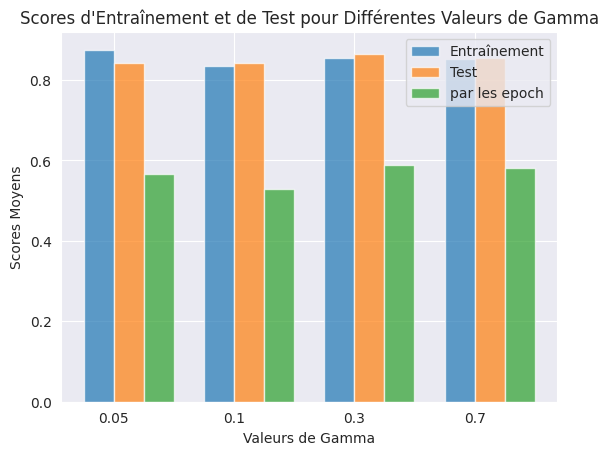

In [23]:
gammas=list(dict.keys())
train_scores=[]
test_scores=[]
epoch_scores=[]
for i in gammas:
    train_scores.append(dict[i][2])
    test_scores.append(dict[i][1])
    epoch_scores.append(dict[i][0])
bar_width = 0.25
index = np.arange(len(gammas))

plt.bar(index, train_scores, bar_width, label='Entraînement', alpha=0.7)
plt.bar(index + bar_width, test_scores, bar_width, label='Test', alpha=0.7)
plt.bar(index + 2*bar_width, epoch_scores, bar_width, label='par les epoch', alpha=0.7)


# Ajouter des étiquettes et une légende
plt.xlabel('Valeurs de Gamma')
plt.ylabel('Scores Moyens')
plt.title('Scores d\'Entraînement et de Test pour Différentes Valeurs de Gamma')
plt.xticks(index + bar_width / 2, gammas)
plt.legend()

# Afficher la figure
plt.show()


**Interprétation et conclusion**

Après analyse, il est observé que pour une valeur de gamma égale à 0.3, les performances moyennes sur l'ensemble des tests, aussi bien sur les données d'entraînement que sur les données de test, ne montrent pas de différences significatives. Ceci suggère que le modèle a bien appris les caractéristiques des données pendant l'entraînement. Toutefois, bien que les performances sur les données d'entraînement soient satisfaisantes, la moyenne des performances sur les données de validation (effectué à chaque époque) n'est pas aussi élevée que prévu, ce qui suggère que le modèle n'a peut-être pas encore convergé vers l'optimum. Il reste donc des possibilités d'amélioration.

Il est donc envisagé d'explorer d'autres configurations en faisant varier le nombre d'époques pour voir si cela peut améliorer les performances globales du modèle.


## Entraînement

* Pour un problème binaire multilabel de détection d'images, où chaque image peut avoir plusieurs étiquettes, BCELoss est une fonction de perte appropriée. Elle est conçue pour traiter des tâches de classification binaire, et dans ce contexte, elle peut être étendue pour gérer plusieurs étiquettes par image de manière efficace. BCELoss mesure l'erreur entre les prédictions du modèle et les étiquettes réelles pour chaque classe indépendamment. Si nous voulons choisir BCEWithLogitsLoss nous devons enlever la dernière couche d'activation avec la fonction sigmoid parce qu'elle combine BCELoss et une couche sigmoid en une même classe.
* L'optimiseur Adam est un choix courant pour les réseaux de neurones convolutifs. Il adapte automatiquement le taux d'apprentissage pour chaque paramètre du réseau, ce qui peut être avantageux pour les tâches complexes comme la détection d'images.
* Le scheduler StepLR est utilisé pour ajuster le taux d'apprentissage à des étapes spécifiques définies par step_size. Dans le contexte de la détection d'images, il peut être bénéfique de réduire progressivement le taux d'apprentissage après un certain nombre d'époques pour stabiliser l'entraînement. Cela peut aider à éviter une convergence trop rapide et à permettre au modèle de mieux généraliser aux données de validation et de test.


### Code appelant la fonction d'entrainement (nombre d'epochs 5)

In [24]:
import torch.optim as optim
from torch.optim import lr_scheduler

nlabel=10
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader
tag="my_model"



# Transfer network to GPU
network=SimpleCNN()
network=network.cuda()

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_dataloader),gamma=0.3)
# Learning
learned_model, train_acc, test_accuracy, train_loss= train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer,scheduler, num_epochs=5)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
train_accs=[]
test_accuracies=[]
train_losses=[]
train_accs.append(train_acc)
test_accuracies.append(test_accuracy)
train_losses.append(train_loss)


Epoch 0/4
----------
Training Loss: 0.5240 | Epoch Accuracy: 0.1408
Epoch 1/4
----------
Training Loss: 0.3749 | Epoch Accuracy: 0.2428
Epoch 2/4
----------
Training Loss: 0.2776 | Epoch Accuracy: 0.4165
Epoch 3/4
----------
Training Loss: 0.2109 | Epoch Accuracy: 0.4303
Epoch 4/4
----------
Training Loss: 0.1680 | Epoch Accuracy: 0.3805


### Code appelant la fonction d'entrainement (nombre d'epochs 12)

In [25]:
import torch.optim as optim
from torch.optim import lr_scheduler

nlabel=10

# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader
tag="my_model"



# Transfer network to GPU
network=SimpleCNN()
network=network.cuda()

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_dataloader),gamma=0.3)

# Learning
learned_model, train_acc, test_accuracy, train_loss = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=12)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
train_accs.append(train_acc)
test_accuracies.append(test_accuracy)
train_losses.append(train_loss)


Epoch 0/11
----------
Training Loss: 0.5337 | Epoch Accuracy: 0.0745
Epoch 1/11
----------
Training Loss: 0.4276 | Epoch Accuracy: 0.1660
Epoch 2/11
----------
Training Loss: 0.3297 | Epoch Accuracy: 0.2820
Epoch 3/11
----------
Training Loss: 0.2420 | Epoch Accuracy: 0.5062
Epoch 4/11
----------
Training Loss: 0.1862 | Epoch Accuracy: 0.6113
Epoch 5/11
----------
Training Loss: 0.1524 | Epoch Accuracy: 0.6465
Epoch 6/11
----------
Training Loss: 0.1121 | Epoch Accuracy: 0.7400
Epoch 7/11
----------
Training Loss: 0.0939 | Epoch Accuracy: 0.7545
Epoch 8/11
----------
Training Loss: 0.0888 | Epoch Accuracy: 0.7800
Epoch 9/11
----------
Training Loss: 0.0785 | Epoch Accuracy: 0.8975
Epoch 10/11
----------
Training Loss: 0.0716 | Epoch Accuracy: 0.8133
Epoch 11/11
----------
Training Loss: 0.0847 | Epoch Accuracy: 0.8768


### Code appelant la fonction d'entrainement (nombre d'epochs 17)

In [26]:
import torch.optim as optim
from torch.optim import lr_scheduler

nlabel=10

# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader
tag="my_model"



# Transfer network to GPU
network=SimpleCNN()
network=network.cuda()

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_dataloader),gamma=0.3)

# Learning
learned_model, train_acc, test_accuracy, train_loss = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=17)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

train_accs.append(train_acc)
test_accuracies.append(test_accuracy)
train_losses.append(train_loss)


Epoch 0/16
----------
Training Loss: 0.5299 | Epoch Accuracy: 0.1110
Epoch 1/16
----------
Training Loss: 0.3777 | Epoch Accuracy: 0.2480
Epoch 2/16
----------
Training Loss: 0.2763 | Epoch Accuracy: 0.3807
Epoch 3/16
----------
Training Loss: 0.2160 | Epoch Accuracy: 0.5875
Epoch 4/16
----------
Training Loss: 0.1566 | Epoch Accuracy: 0.5255
Epoch 5/16
----------
Training Loss: 0.1322 | Epoch Accuracy: 0.7658
Epoch 6/16
----------
Training Loss: 0.0966 | Epoch Accuracy: 0.6098
Epoch 7/16
----------
Training Loss: 0.0921 | Epoch Accuracy: 0.8535
Epoch 8/16
----------
Training Loss: 0.0743 | Epoch Accuracy: 0.8478
Epoch 9/16
----------
Training Loss: 0.0905 | Epoch Accuracy: 0.8065
Epoch 10/16
----------
Training Loss: 0.0652 | Epoch Accuracy: 0.8545
Epoch 11/16
----------
Training Loss: 0.0613 | Epoch Accuracy: 0.8313
Epoch 12/16
----------
Training Loss: 0.0528 | Epoch Accuracy: 0.9280
Epoch 13/16
----------
Training Loss: 0.0546 | Epoch Accuracy: 0.9103
Epoch 14/16
----------
Trainin

### Code appelant la fonction d'entrainement (nombre d'epochs 20)

In [27]:
import torch.optim as optim
from torch.optim import lr_scheduler

nlabel=10

# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader
tag="my_model"



# Transfer network to GPU
network=SimpleCNN()
network=network.cuda()

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_dataloader),gamma=0.3)


# Learning
learned_model, train_acc, test_accuracy, train_loss = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=20)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

train_accs.append(train_acc)
test_accuracies.append(test_accuracy)
train_losses.append(train_loss)


Epoch 0/19
----------
Training Loss: 0.5332 | Epoch Accuracy: 0.1228
Epoch 1/19
----------
Training Loss: 0.4088 | Epoch Accuracy: 0.1668
Epoch 2/19
----------
Training Loss: 0.3171 | Epoch Accuracy: 0.3345
Epoch 3/19
----------
Training Loss: 0.2343 | Epoch Accuracy: 0.5010
Epoch 4/19
----------
Training Loss: 0.1766 | Epoch Accuracy: 0.6265
Epoch 5/19
----------
Training Loss: 0.1311 | Epoch Accuracy: 0.6705
Epoch 6/19
----------
Training Loss: 0.1320 | Epoch Accuracy: 0.7010
Epoch 7/19
----------
Training Loss: 0.1061 | Epoch Accuracy: 0.7575
Epoch 8/19
----------
Training Loss: 0.0911 | Epoch Accuracy: 0.8528
Epoch 9/19
----------
Training Loss: 0.0760 | Epoch Accuracy: 0.7193
Epoch 10/19
----------
Training Loss: 0.0639 | Epoch Accuracy: 0.8775
Epoch 11/19
----------
Training Loss: 0.0537 | Epoch Accuracy: 0.8470
Epoch 12/19
----------
Training Loss: 0.0547 | Epoch Accuracy: 0.9085
Epoch 13/19
----------
Training Loss: 0.0537 | Epoch Accuracy: 0.7438
Epoch 14/19
----------
Trainin

### Visualisation des résultats

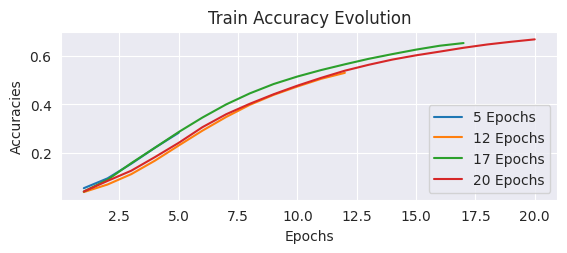

In [33]:
# Find the maximum length of sublists for accuracy
max_length_acc = max(len(sublist) for sublist in train_accs)
# Pad or truncate the sublists to have the same length
padded_train_accs = [sublist + [np.nan] * (max_length_acc - len(sublist)) for sublist in train_accs]



# Plotting Accuracy
indices_to_plot = [5, 12, 17, 20]
plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot in the first position
for i in range(4):
    scores = padded_train_accs[i]
    plt.plot(range(1, len(scores) + 1), scores, label=f'{indices_to_plot[i]} Epochs')

plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Train Accuracy Evolution')
plt.legend()




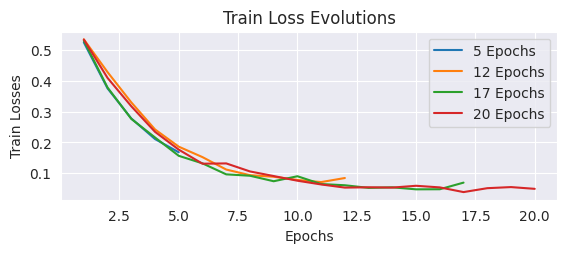

In [34]:
# Find the maximum length of sublists for loss
max_length_loss = max(len(sublist) for sublist in train_losses)
# Pad or truncate the sublists to have the same length
padded_train_losses = [sublist + [np.nan] * (max_length_loss - len(sublist)) for sublist in train_losses]
# Plotting Loss
plt.subplot(2, 1, 2)
for i in range(4):
    scores = padded_train_losses[i]
    plt.plot(range(1, len(scores) + 1), scores, label=f'{indices_to_plot[i]} Epochs')

plt.xlabel('Epochs')
plt.ylabel('Train Losses')
plt.title('Train Loss Evolutions')
plt.legend()


**Interprétation**

La courbe d'évolution de l'exactitude d'entraînement montre une amélioration continue avec le nombre croissant d'époques. Les courbes correspondant à un plus grand nombre d'époques se situent au-dessus, indiquant un apprentissage plus approfondi du modèle. Cela suggère une meilleure adaptation aux données d'entraînement à mesure que l'entraînement progresse.

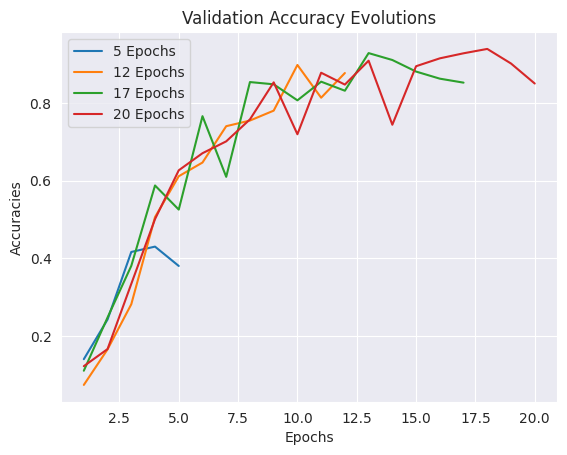

In [35]:
# Find the maximum length of sublists
max_length = max(len(sublist) for sublist in train_accs)

# Pad or truncate the sublists to have the same length
padded_test_accuracies = [sublist + [np.nan] * (max_length - len(sublist)) for sublist in test_accuracies]

# Plotting
for i in range(4):
    scores = padded_test_accuracies[i]
    plt.plot(range(1, len(scores) + 1), scores, label=f'{indices_to_plot[i]} Epochs')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Validation Accuracy Evolutions')
plt.legend()

# Show the plot
plt.show()



**Interprétation**


Il est évident que lorsque le nombre d'époques est égal à 17 ou 20, les oscillations diminuent, suggérant ainsi une convergence vers l'optimum après un certain nombre d'époques. En revanche, dans les cas où le nombre d'époques est de 5 ou 12, les oscillations sont très prononcées, ce qui indique que le minimum global n'est pas atteint, et par conséquent, la convergence n'est pas assurée pour ces valeurs.

### Interprétation et conclusion
Avec un taux de décroissance (gamma) égal à 0.3, on interprète que le modèle atteint une performance significative après 17 époques, en se basant sur la valeur de précision de la dernière validation. En considérant également le temps d'exécution, comparé à un scénario avec 20 époques, on conclut que 17 époques, avec un gamma de 0.3, sont suffisantes pour obtenir des prédictions correctes. Le réseau sera testé après avoir été entraîné avec 17 époques.

**Entrainement avec gamma=0.3 et nombre d'époques=17**


In [36]:
import torch.optim as optim
from torch.optim import lr_scheduler

nlabel=10

# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader
tag="my_model"

# Transfer network to GPU
network=SimpleCNN()
network=network.cuda()

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=len(train_dataloader),gamma=0.3)

# Learning
learned_model, train_acc, test_accuracy, train_loss = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=17)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

Epoch 0/16
----------
Training Loss: 0.5199 | Epoch Accuracy: 0.1430
Epoch 1/16
----------
Training Loss: 0.3574 | Epoch Accuracy: 0.1680
Epoch 2/16
----------
Training Loss: 0.2636 | Epoch Accuracy: 0.3123
Epoch 3/16
----------
Training Loss: 0.2104 | Epoch Accuracy: 0.5918
Epoch 4/16
----------
Training Loss: 0.1727 | Epoch Accuracy: 0.5797
Epoch 5/16
----------
Training Loss: 0.1321 | Epoch Accuracy: 0.7355
Epoch 6/16
----------
Training Loss: 0.1154 | Epoch Accuracy: 0.8280
Epoch 7/16
----------
Training Loss: 0.0996 | Epoch Accuracy: 0.7653
Epoch 8/16
----------
Training Loss: 0.0754 | Epoch Accuracy: 0.8285
Epoch 9/16
----------
Training Loss: 0.0824 | Epoch Accuracy: 0.7720
Epoch 10/16
----------
Training Loss: 0.0721 | Epoch Accuracy: 0.8665
Epoch 11/16
----------
Training Loss: 0.0708 | Epoch Accuracy: 0.8928
Epoch 12/16
----------
Training Loss: 0.0694 | Epoch Accuracy: 0.8678
Epoch 13/16
----------
Training Loss: 0.0557 | Epoch Accuracy: 0.9090
Epoch 14/16
----------
Trainin

## Test du modèle entraîné

In [37]:
testloader = test_dataloader
network=torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
# set the model to evaluation mode
network.eval()
# create the per
all_labels=[]
all_preds=[]
scores=[]
# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(testloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)
        threshold = 0.5
        preds = (outputs > threshold).float()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(targets.cpu().numpy())
        outputs_np = outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()

        scores.append(accuracy_score(targets.cpu(),preds.cpu()))
        # update the performance

all_preds_np = np.concatenate(all_preds)
all_labels_np = np.concatenate(all_labels)
print()
print("Les performances globales : ",np.array(scores).mean())

100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.22it/s]


Les performances globales :  0.9277272727272727


**Enfin, notre modèle est désormais capable de prédire correctement 90 % de toutes les images de test.**

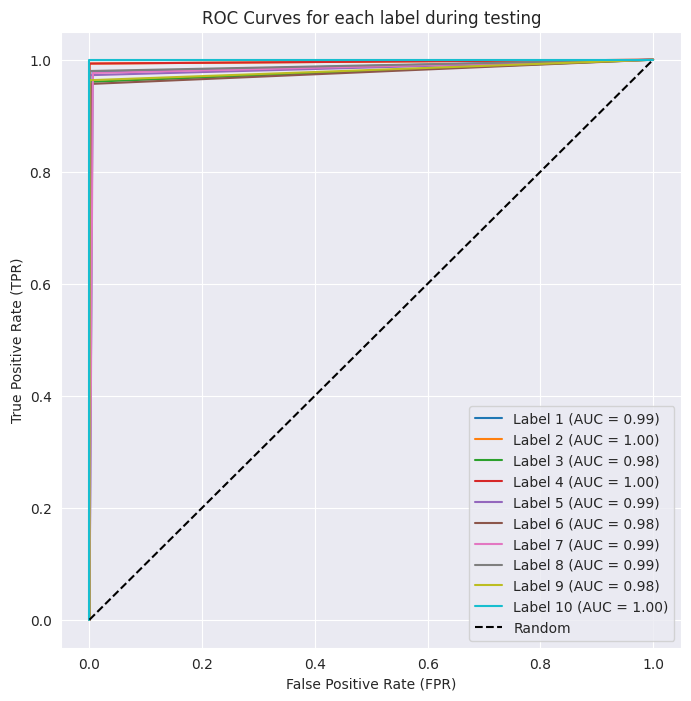

In [38]:
# Plot ROC curves for each class
plt.figure(figsize=(8, 8))
for i in range(nlabel):
    fpr, tpr, _ = roc_curve(all_labels_np[:, i], all_preds_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Label {i+1} (AUC = {roc_auc:.2f})')

# Plot the random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Set labels and title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for each label during testing')
plt.legend()

# Show the plot
plt.show()

**Interprétation** :
L'observation de la courbe ROC, qui affiche une trajectoire ascendante vers le coin supérieur gauche, est particulièrement encourageante. Cette caractéristique suggère que notre modèle excelle dans la discrimination des toppings sur une pizza. La position dans le quadrant supérieur gauche indique un équilibre optimal entre la sensibilité (capacité à détecter les toppings positifs) et la spécificité (capacité à éviter les faux positifs). La surface sous la courbe ROC (AUC) étant significative, cela témoigne de la performance globale exceptionnelle du modèle dans la résolution du problème multilabel de détection des toppings.

**Si on teste les performances du modéles par label**


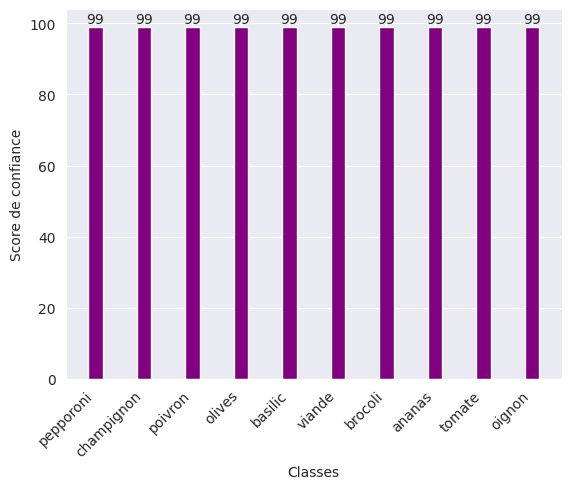

In [39]:
per_label=[]
somme=0
totale=0
for k in range(10):
    for i in range(len(all_preds)):
        for j in range(all_preds[i].shape[0]):
            totale+=1
            if (all_preds[i][j,k]==all_labels[i][j,k]):
                somme+=1
    per_label.append(somme*100/totale)
per_label = [round(nombre) for nombre in per_label]

fig, ax = plt.subplots()

ax.bar(classes, per_label, color='purple',width=0.3)
for classe, valeur in zip(classes, per_label):
    ax.text(classe, valeur + 1, str(valeur), ha='center')
    plt.xticks(range(len(per_label)), classes, rotation=45, ha='right')

plt.xlabel('Classes')
plt.ylabel('Score de confiance')
plt.show()


Il est clairement observable que le programme est performant pour chaque étiquette, démontrant une précision notable sans confusion entre les différentes étiquettes.

# Cette partie est conçue pour la prediction des étiquettes d'une image donée en utlisant les fonction show_img et predict single

In [40]:
def show_image(img,label):


  plt.imshow(img)
  print("Votre pizza est composé de :",decode_label(label))

#####


def predict_single(idx):
    img_name="{:04d}.png".format(idx)

    img_path=os.path.join(DATA_DIR,'syntheticDataset/test/images')
    img=Image.open(os.path.join(img_path,img_name))
    x,_=test_set_raw[idx-1]
    x=x.unsqueeze(0)
    x=x.cuda()
    prediction=network(x)
    preds=(prediction>0.5).int()
    preds=preds.cpu().detach().numpy()

    preds=np.squeeze(preds)
    show_image(img,preds)

Votre pizza est composé de : pepporoni/olives/brocoli/tomate


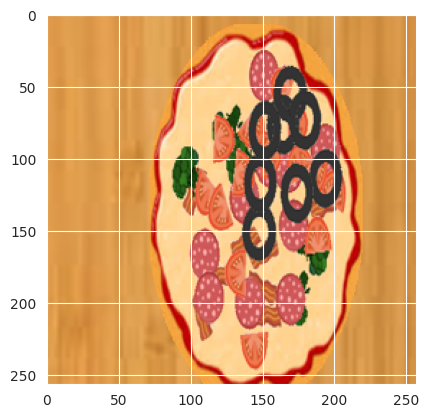

In [41]:
idx=250
x,_=test_set_raw[idx-1]
predict_single(idx)


## Conclusion
En conclusion, les performances de notre modèle sont remarquables, comme en témoignent la courbe ROC et les scores de confiance. Cependant, des possibilités d'amélioration visant à augmenter le score de confiance à détecter tous les toppings dans une image subsistent. L'ajout de couches au réseau pourrait potentiellement renforcer sa capacité de représentation, mais cela doit être équilibré avec les contraintes de mémoire existantes. De même, la diminution du paramètre gamma et l'augmentation du nombre d'époques d'entraînement peuvent améliorer la convergence du modèle, mais ces ajustements doivent être évalués en tenant compte des contraintes de temps d'exécution. En explorant ces ajustements tout en gérant ces compromis, nous pourrions encore optimiser les performances de notre modèle pour une détection plus précise.